In [1]:
# libraries
import os
import subprocess
import numpy as np
import pandas as pd
import scipy
from scipy import signal
import ripple_detection
from ripple_detection import filter_ripple_band
import numpy as np
from scipy.interpolate import interp1d
from scipy.signal import windows
from scipy.ndimage import convolve
from scipy import stats
from tqdm import tqdm
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from scipy import interpolate
from scipy.signal import firwin, lfilter
from fitter import Fitter, get_common_distributions, get_distributions
import time
import re
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.stats import zscore
from scipy.ndimage.filters import gaussian_filter
import glob
import pickle

plt.rcParams["svg.fonttype"] = "none"
plt.rcParams["text.usetex"] = False
plt.rcParams["font.weight"] = "bold"

/home/acampbell/miniconda3/envs/allensdk_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModuleNotFoundError: No module named 'fitter'

In [2]:
gamma_filter_path = "/home/acampbell/NeuropixelsLFPOnRamp/PowerBandFilters/swr_detection_script_filters_1500Hz/frank2008_gamma_1500hz_bandpass_filter.npz"
# The path to the theta filter
theta_filter_path = "/home/acampbell/NeuropixelsLFPOnRamp/PowerBandFilters/swr_detection_script_filters_1500Hz/theta_1500hz_bandpass_filter.npz"
# The ripple band threshold

# loading filters (craetes artifacts in first and last ~ 3.5 seconds of recordings, remember to clip these off)
gamma_filter = np.load(gamma_filter_path)
gamma_filter = gamma_filter["arr_0"]

theta_filter = np.load(theta_filter_path)
theta_filter = theta_filter["arr_0"]
sdk_cache_dir = "/space/scratch/allen_viscoding_data"
# Setting up the ABI Cache (where data is held, what is present or absent)
manifest_path = os.path.join(sdk_cache_dir, "manifest.json")

cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

# we start by calling and filtering our dataframe of the sessions we will be working with
sessions = cache.get_session_table()

In [ ]:
# change this to your local
abi_swrs_dir_path = (
    "/space/scratch/SWR_final_pipeline/osf_campbellmurphy2025_v2_final/allen_viscoding_swr_murphylab2024"
)
abi_lfp_dir_path = (
    "/space/scratch/SWR_final_pipeline/osf_campbellmurphy2025_v2_final/allen_viscoding_swr_murphylab2024_lfp_data"
)

## Number of ripples by thresholds

In [16]:
abi_ripples_path = (
    "/space/scratch/allen_visbehave_swr_data/allen_viscoding_swr_murphylab2024"
)
abi_lfp_path = (
    "/space/scratch/allen_visbehave_swr_data/allen_viscoding_swr_murphylab2024_lfp_data"
)
theta_filter_path = "/home/acampbell/NeuropixelsLFPOnRamp/PowerBandFilters/swr_detection_script_filters_1500Hz/theta_1500hz_bandpass_filter.npz"
theta_filter = np.load(theta_filter_path)
theta_filter = theta_filter["arr_0"]

## Plotting all SWRs as a function of speed and theta

In [18]:
abi_ripples_path = (
    "/space/scratch/allen_visbehave_swr_data/allen_viscoding_swr_murphylab2024"
)
abi_lfp_path = (
    "/space/scratch/allen_visbehave_swr_data/allen_viscoding_swr_murphylab2024_lfp_data"
)
theta_filter_path = "/home/acampbell/NeuropixelsLFPOnRamp/PowerBandFilters/swr_detection_script_filters_1500Hz/theta_1500hz_bandpass_filter.npz"
theta_filter = np.load(theta_filter_path)
theta_filter = theta_filter["arr_0"]

In [19]:
def smoothed_vel_from_runningspeed_df(velocity_df):
    """
    Function to convert running speed DataFrame to smoothed velocity array.

    Parameters:
    velocity_df (pd.DataFrame): DataFrame with columns 'start_time', 'end_time', and 'velocity'.

    Returns:
    np.array: Smoothed velocity array.
    time_array: Time array corresponding to the smoothed velocity array.

    """
    velocity_df["time_interval"] = velocity_df["end_time"] - velocity_df["start_time"]

    # Determine the total number of points required at 1500 Hz
    total_points = int(velocity_df["time_interval"].sum() * 1500)

    # Create a time array with the desired number of points
    time_array = np.linspace(
        velocity_df["start_time"].iloc[0],
        velocity_df["end_time"].iloc[-1],
        total_points,
    )

    # Interpolate the velocity signal at 1500 Hz
    interpolated_velocity = interp1d(
        np.hstack((velocity_df["start_time"].values, velocity_df["end_time"].iloc[-1])),
        np.hstack((velocity_df["velocity"].values, velocity_df["velocity"].iloc[-1])),
        kind="linear",
    )(time_array)

    # Create a half Gaussian window for smoothing
    window = windows.gaussian(31, std=0.25)
    window = window / np.sum(window)

    # Smooth the interpolated velocity signal
    smoothed_velocity = convolve(interpolated_velocity, window, mode="reflect")

    # Return the smoothed velocity as a 1D NumPy array

    return np.array(smoothed_velocity), time_array

The code to collect the data used for plotting histograms and computing distributions takes a very long time to run so it has been commented out here.

In [20]:
"""
speeds = []
theta_powers = {'peakwindow_med':[],'peakwindow_mean':[],
                'eventwindow_med':[],'eventwindow_mean':[]}
theta_compute_halfwindow = 0.125
failed_sesh = []

for sessionfolder in os.listdir(abi_ripples_path):
    try:
        if '.csv' in sessionfolder:
            continue 
        folder_path = os.path.join(abi_ripples_path, sessionfolder)
        folderfiles = os.listdir(folder_path)

        global_ripples_filename = [file for file in folderfiles if 'global_swrs' in file][0]

        global_ripples_df = pd.read_csv(os.path.join(folder_path, global_ripples_filename), compression='gzip')
        session_id = int(sessionfolder.split('_')[-1])
        
        # getting speeds
        session = cache.get_session_data(session_id)
        wheel_velocity, wheel_time = smoothed_vel_from_runningspeed_df(session.running_speed)
        
        # Interpolating the wheel velocity to 1500 Hz
        interp_func = interp1d(wheel_time, wheel_velocity)
        wheel_time = np.linspace(wheel_time[0], wheel_time[-1], int(len(wheel_time) * 1500 / len(wheel_time)))
        wheel_velocity = interp_func(wheel_time)
        
        average_speeds = []
        for _, row in global_ripples_df.iterrows():
            start_time = row['start_time']
            end_time = row['end_time']
            mask = (wheel_time >= start_time) & (wheel_time <= end_time)
            average_speed = np.abs(wheel_velocity[mask]).mean()
            average_speeds.append(average_speed)
        
        global_ripples_df['average_speed'] = average_speeds
        speeds.extend(average_speeds)
        
        lfp_session_path = f"{abi_lfp_path}/lfp_session_{str(session_id)}"
        lfp_files = os.listdir(lfp_session_path)
        for file in folderfiles:
            # we load lfp data for the karlsson files, then we compute theta power (zscored) and take that values
            # in a window around the peak of the swr
            if not 'karlsson' in file:
                continue
            
            # load the data
            events_df = pd.read_csv(os.path.join(folder_path,file), compression ='gzip')
            events_df = events_df[(events_df.Overlaps_with_gamma==True) & (events_df.Overlaps_with_movement==True)]
            probe_id = re.search(r'probe_(.*?)_', file).group(1)
            channel_indx = re.search(r'channel_(.*?)_', file).group(1)
            lfp_data = [file for file in lfp_files if f"channel_{channel_indx}" in file and probe_id in file and "ca1_peakripplepower.npz" in file]
            lfp_data = np.load(os.path.join(lfp_session_path,lfp_data[0]))
            lfp_data = lfp_data['lfp_ca1']
            lfp_times = [file for file in lfp_files if f"channel_{channel_indx}" in file and probe_id in file and "time_index_1500hz.npz" in file]
            lfp_times = np.load(os.path.join(lfp_session_path,lfp_times[0]))
            lfp_times = lfp_times['lfp_time_index']
            
            # compute theta power
            #theta_pow_zscore = np.convolve(lfp_data, theta_filter, mode='same')
            theta_pow_zscore = np.convolve(lfp_data.flatten(), theta_filter.flatten(), mode='same')
            theta_pow_zscore = scipy.stats.zscore(np.abs(signal.hilbert(theta_pow_zscore))**2)
            
            for _, event in events_df.iterrows():
                # Compute median and mean for peak window
                peak_start = event['Peak_time'] - theta_compute_halfwindow
                peak_end = event['Peak_time'] + theta_compute_halfwindow
                peak_window_data = theta_pow_zscore[(lfp_times >= peak_start) & (lfp_times <= peak_end)]
                theta_powers['peakwindow_med'].append(np.median(peak_window_data))
                theta_powers['peakwindow_mean'].append(np.mean(peak_window_data))

                # Compute median and mean for event window
                event_window_data = theta_pow_zscore[(lfp_times >= event['start_time']) & (lfp_times <= event['end_time'])]
                theta_powers['eventwindow_med'].append(np.median(event_window_data))
                theta_powers['eventwindow_mean'].append(np.mean(event_window_data))
    except:
        failed_sesh.append(sessionfolder)
"""

# saved to avoid having to regenerate it, only used in debugging, will delete in and this seciton later

# save the speeds and theta powers
# with open('abi_viscoding_theta.pkl', 'wb') as f:
#    pickle.dump(theta_powers, f)

# Save the numpy array
# np.save('abi_viscoding_speeds.npy', speeds)

'\nspeeds = []\ntheta_powers = {\'peakwindow_med\':[],\'peakwindow_mean\':[],\n                \'eventwindow_med\':[],\'eventwindow_mean\':[]}\ntheta_compute_halfwindow = 0.125\nfailed_sesh = []\n\nfor sessionfolder in os.listdir(abi_ripples_path):\n    try:\n        if \'.csv\' in sessionfolder:\n            continue \n        folder_path = os.path.join(abi_ripples_path, sessionfolder)\n        folderfiles = os.listdir(folder_path)\n\n        global_ripples_filename = [file for file in folderfiles if \'global_swrs\' in file][0]\n\n        global_ripples_df = pd.read_csv(os.path.join(folder_path, global_ripples_filename), compression=\'gzip\')\n        session_id = int(sessionfolder.split(\'_\')[-1])\n        \n        # getting speeds\n        session = cache.get_session_data(session_id)\n        wheel_velocity, wheel_time = smoothed_vel_from_runningspeed_df(session.running_speed)\n        \n        # Interpolating the wheel velocity to 1500 Hz\n        interp_func = interp1d(wheel_ti

In [21]:
# Load data from pickle file
with open("abi_viscoding_theta.pkl", "rb") as f:
    theta_powers = pickle.load(f)

# Load data from numpy file
speeds = np.load("abi_viscoding_speeds.npy")

In [22]:
columns = ["peakwindow_med", "peakwindow_mean", "eventwindow_med", "eventwindow_mean"]
nan_indices = []
cleaned_theta_data = {}

for col in columns:
    data = pd.Series(theta_powers[col])
    nan_index = data.index[data.isna()].tolist()
    nan_indices.append(set(nan_index))
    cleaned_theta_data[col] = data.dropna()

# Check if all NaN indices are the same
if len(set.intersection(*nan_indices)) == len(nan_indices[0]):
    print("All NaN indices are the same.")
else:
    print("NaN indices are not the same.")

# Print min and max values of cleaned data
for col, data in cleaned_theta_data.items():
    print(f"For {col}, Min: {data.min()}, Max: {data.max()}")

All NaN indices are the same.
For peakwindow_med, Min: -1.954519408622036, Max: 81.07365972522912
For peakwindow_mean, Min: -1.819185503569708, Max: 76.2166622596301
For eventwindow_med, Min: -1.9664677921337348, Max: 95.58100493862955
For eventwindow_mean, Min: -1.965567696573613, Max: 91.4388993312975


In [23]:
figure_six_path = "/home/acampbell/NeuropixelsLFPOnRamp/Figures_and_Technical_Validation/figures/figure6/"

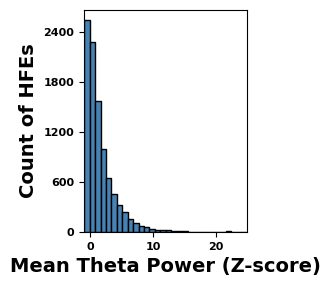

In [24]:
# Ensure text is exported as text objects
plt.rcParams["svg.fonttype"] = "none"
plt.rcParams["text.usetex"] = False  # Do not use LaTeX for rendering text
plt.rcParams["font.weight"] = "bold"
plt.rcParams["pdf.use14corefonts"] = False
plt.rcParams["font.size"] = 8
plt.rcParams["axes.titleweight"] = "bold"  # Make the title bold
plt.rcParams["axes.labelweight"] = "bold"

# set figzise in mm
width_mm = 66
height_mm = 73.75

# Set figure size in inches
plt.figure(figsize=(width_mm / 25.4, height_mm / 25.4))

plt.hist(
    cleaned_theta_data["peakwindow_mean"],
    bins=90,
    edgecolor="black",
    facecolor="steelblue",
)
plt.xlim(-1, 25)
plt.xlabel("Mean Theta Power (Z-score)", fontsize=14, weight="bold")
plt.ylabel("Count of HFEs", fontsize=14, weight="bold")
# plt.title('Computed around Peak Window')

# Reduce the number of y-ticks
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(5))

plt.tight_layout()
plt.savefig(f"{figure_six_path}six_coding_a.svg", format="svg")
plt.show()

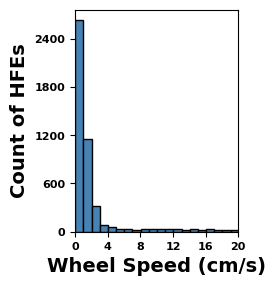

In [25]:
# Ensure text is exported as text objects
plt.rcParams["svg.fonttype"] = "none"
plt.rcParams["text.usetex"] = False  # Do not use LaTeX for rendering text
plt.rcParams["font.weight"] = "bold"
plt.rcParams["pdf.use14corefonts"] = False
plt.rcParams["font.size"] = 8
plt.rcParams["axes.titleweight"] = "bold"  # Make the title bold
plt.rcParams["axes.labelweight"] = "bold"

# set figzise in mm
width_mm = 66
height_mm = 73.75

# Set figure size in inches
plt.figure(figsize=(width_mm / 25.4, height_mm / 25.4))

plt.hist(speeds, bins=100, edgecolor="black", facecolor="steelblue")
# Ensure text is exported as text objects
plt.rcParams["svg.fonttype"] = "none"
plt.rcParams["text.usetex"] = False  # Do not use LaTeX for rendering text
plt.xlim(0, 20)
plt.xlabel("Wheel Speed (cm/s)", fontsize=14, weight="bold")
plt.ylabel("Count of HFEs", fontsize=14, weight="bold")

# Reduce the number of y-ticks
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(5))
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(5))


plt.tight_layout()
plt.savefig(f"{figure_six_path}six_coding_c.svg", format="svg")
plt.show()

## Ripple Distributions

In [26]:
# getting
directories = os.listdir(abi_ripples_path)

processed_sesh_ids = [
    dir.replace("swrs_session_", "") for dir in directories if "swrs_session_" in dir
]

print(processed_sesh_ids)

['797828357', '821695405', '750749662', '816200189', '835479236', '774875821', '762602078', '760345702', '750332458', '794812542', '719161530', '779839471', '839068429', '751348571', '829720705', '793224716', '757216464', '763673393', '789848216', '761418226', '778998620', '771990200', '767871931', '757970808', '773418906', '781842082', '787025148', '755434585', '786091066', '766640955', '758798717', '799864342', '831882777', '754829445', '819186360', '791319847', '746083955', '771160300', '798911424', '743475441', '744228101', '768515987', '759883607', '819701982', '754312389', '721123822', '778240327']


In [27]:
all_swrs_df = pd.DataFrame()
global_swr_failed_session = []
for sessionfolder in os.listdir(abi_ripples_path):
    try:
        if "global_swrs_no_movement_no_gamma.csv" in sessionfolder:
            continue
        folder_path = os.path.join(abi_ripples_path, sessionfolder)
        folderfiles = os.listdir(folder_path)
        try:
            global_ripples_filename = [
                file for file in folderfiles if "global_swrs" in file
            ][0]

        except:
            continue
        global_ripples_df = pd.read_csv(
            os.path.join(folder_path, global_ripples_filename), compression="gzip"
        )
        global_ripples_df["duration"] = (
            global_ripples_df["end_time"] - global_ripples_df["start_time"]
        )
        global_ripples_df["session_id"] = sessionfolder.replace("swrs_session_", "")
        all_swrs_df = pd.concat([all_swrs_df, global_ripples_df])
    except:
        global_swr_failed_session.append(sessionfolder)

Using fitter we can asses the fit with the KS test and the SSE, and get a p-value from the KS-test.  

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
lognorm,0.000002,2126.774955,-1.050480e+07,inf,0.013437,3.087147e-64
halfnorm,0.000061,4992.406710,-9.204211e+06,inf,0.085834,0.000000e+00
norm,0.000147,8661.229904,-8.845885e+06,inf,0.138218,0.000000e+00


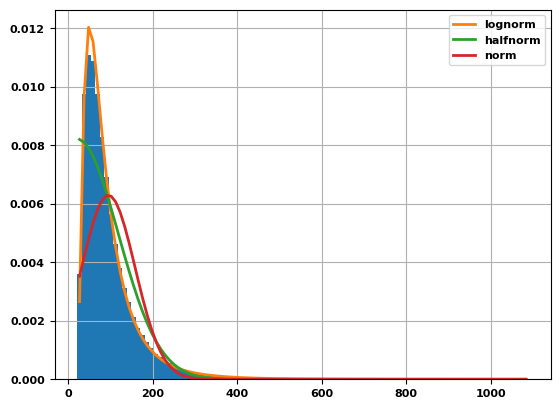

In [28]:
f_distributions_dur = Fitter(
    all_swrs_df["duration"] * 1000, distributions=["norm", "lognorm", "halfnorm"]
)
f_distributions_dur.fit()
f_distributions_dur.summary()

We can also use fitter for plotting the distribution with the fits, though this requires a bit of adjusting the plots

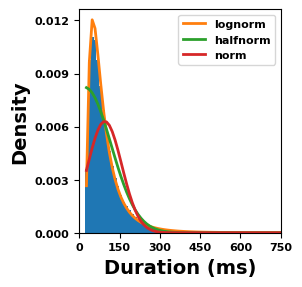

In [29]:
# Ensure text is exported as text objects
plt.rcParams["svg.fonttype"] = "none"
plt.rcParams["text.usetex"] = False  # Do not use LaTeX for rendering text
plt.rcParams["font.weight"] = "bold"
plt.rcParams["pdf.use14corefonts"] = False
plt.rcParams["font.size"] = 8
plt.rcParams["axes.titleweight"] = "bold"  # Make the title bold
plt.rcParams["axes.labelweight"] = "bold"

# set figzise in mm
width_mm = 66
height_mm = 73.75

# Set figure size in inches
plt.figure(figsize=(width_mm / 25.4, height_mm / 25.4))

# Plot the histogram
f_distributions_dur.hist()

# Plot the PDF
f_distributions_dur.plot_pdf()

# Get the current axes and turn off the grid
ax = plt.gca()
ax.grid(False)
ax.set_xlim(0, 750)

# Set the title and axis labels
ax.set_xlabel("Duration (ms)", fontsize=14, weight="bold")
ax.set_ylabel("Density", fontsize=14, weight="bold")

# Reduce the number of y-ticks
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(5))
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(5))

plt.savefig(f"{figure_six_path}six_coding_e.svg", format="svg")
# Display the plot
plt.show()

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
lognorm,0.005459,2006.846733,-7.374875e+06,inf,0.051863,0.0
halfnorm,0.039698,11511.741750,-6.567685e+06,inf,0.258228,0.0
norm,0.070010,17485.196685,-6.336857e+06,inf,0.234843,0.0


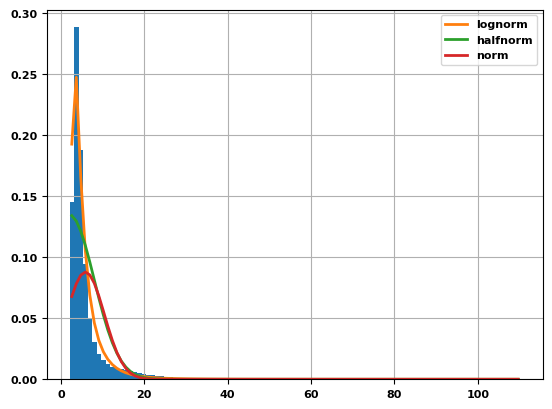

In [30]:
f_distributions_pow = Fitter(
    all_swrs_df["global_max_zscore"], distributions=["norm", "lognorm", "halfnorm"]
)
f_distributions_pow.fit()
f_distributions_pow.summary()

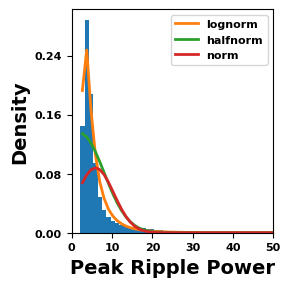

In [31]:
# Ensure text is exported as text objects
plt.rcParams["svg.fonttype"] = "none"
plt.rcParams["text.usetex"] = False  # Do not use LaTeX for rendering text
plt.rcParams["font.weight"] = "bold"
plt.rcParams["pdf.use14corefonts"] = False
plt.rcParams["font.size"] = 8
plt.rcParams["axes.titleweight"] = "bold"  # Make the title bold
plt.rcParams["axes.labelweight"] = "bold"

# set figzise in mm
width_mm = 66
height_mm = 73.75

# Set figure size in inches
plt.figure(figsize=(width_mm / 25.4, height_mm / 25.4))

# Plot the histogram
f_distributions_pow.hist()

# Plot the PDF
f_distributions_pow.plot_pdf()

# Get the current axes and turn off the grid
ax = plt.gca()
ax.grid(False)

# Set x-axis limits
# ax.set_xlim([0, 70])  # replace with your desired limits
# Reduce the number of y-ticks
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(5))
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(5))


# Set the title and axis labels
ax.set_xlabel("Peak Ripple Power", fontsize=14, weight="bold")
ax.set_ylabel("Density", fontsize=14, weight="bold")
ax.set_xlim([0, 50])
plt.savefig(f"{figure_six_path}six_coding_g.svg", format="svg")
# Display the plot
plt.show()